In [1]:
import os, sys, h5py
import numpy as np
from six.moves import cPickle
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('..')
import helper
from residualbind_classify import ResidualBind

Using TensorFlow backend.


In [2]:
data_path = '../../data/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.array(dataset['train_seq']).transpose([0, 2, 1])
    X_train_struct = np.array(dataset['train_structures']).transpose([0, 2, 1])
    Y_train = np.array(dataset['train_targets'])
    X_test_seq = np.array(dataset['test_seq']).transpose([0, 2, 1])
    X_test_struct = np.array(dataset['test_structures']).transpose([0, 2, 1])
    Y_test = np.array(dataset['test_targets'])

num_data, seq_length, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [3]:
save_path = helper.make_directory('../../results', 'hairpin')

In [4]:
# load residualbind model
input_shape = list(train['inputs'].shape)[1:]
weights_path = os.path.join(save_path, 'residualbind_classify_weights.hdf5')    
model = ResidualBind(input_shape, weights_path)

# fit model
model.fit(train, valid, num_epochs=300, batch_size=100, patience=25, 
          lr=0.001, lr_decay=0.3, decay_patience=7)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 192000 samples, validate on 48000 samples
Epoch 1/300


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d/conv1d}}]]
	 [[metrics/acc/Identity/_447]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d/conv1d}}]]
0 successful operations.
0 derived errors ignored.

In [5]:
# evaluate model
corr = model.test_model(test, batch_size=100, weights='best')

# Mutagenesis study

In [13]:

def first_order_mutagenesis(model, X, class_index=0):
    N,L,A = X.shape

    # get wild-type score
    wt_score = model.predict(X)

    # generate mutagenesis sequences
    X_mut = np.dot(np.ones((L*A, 1)), X)
    k = 0
    for i in range(L):
        for j in range(A):
            X_mut[k,i,:] = 0
            X_mut[k,i,j] = 1        
            k += 1

    # get first order mutagenesis score
    mut_scores = model.predict(X_mut)[:,class_index]

    # calculate log-odds score
    mutagenesis = np.log(mut_scores + 1e-7) - np.log(wt_score + 1e-7)
    mutagenesis = np.reshape(mutagenesis, [L, A])
    
    return mutagenesis


def second_order_mutagenesis(model, X, class_index=0):
    N,L,A = X.shape
    
    # get wild-type score
    wt_score = model.predict(X)
    
    # generate second-order mutagenesis sequences
    num_mut = L**2*A**2
    X_mut = np.reshape(np.dot(np.ones((num_mut, 1)), X), [num_mut,L,A])
    k = 0
    for i in range(L):
        for j in range(L):
            for m in range(A):
                for n in range(A):
                    X_mut[k,i,:] = 0
                    X_mut[k,i,m] = 1        
                    X_mut[k,j,:] = 0
                    X_mut[k,j,n] = 1        
                    k += 1

    # get second order mutagenesis score
    mut_scores = model.predict(X_mut)[:,class_index]

    # calculate log-odds score
    log_odds = np.log(mut_scores + 1e-7) - np.log(wt_score + 1e-7)

    # reshape second order scores
    second_mutagenesis = np.zeros((L,L,A,A))
    k = 0
    for i in range(L):
        for j in range(L):
            for m in range(A):
                for n in range(A):
                    second_mutagenesis[i,j,m,n] = log_odds[k]
                    k += 1
                
    return second_mutagenesis

# Perform 1st-order and 2nd-order mutagenesis 

In [14]:
pos_index = np.where(test['targets'][:,0] == 1)[0]

N = 1000#len(pos_index)
mutagenesis_1 = np.zeros((N,L,A))
mutagenesis_2 = np.zeros((N,L,L,A,A))
for i, index in enumerate(pos_index[:N]):
    X = np.expand_dims(test['inputs'][index], axis=0)
    mutagenesis_1[i,:,:] = first_order_mutagenesis(sess, nntrainer, X)
    mutagenesis_2[i,:,:,:,:] = second_order_mutagenesis(sess, nntrainer, X)
    
    if np.mod(i+1, 200) == 0:
        print("%d out of %d"%(i+1,N))
        
# save results to file
with open(os.path.join(save_path, 'mutagenesis_pos.pickle'), 'wb') as f:
    cPickle.dump(mutagenesis_1, f)
    cPickle.dump(mutagenesis_2, f)

200 out of 1000
400 out of 1000
600 out of 1000
800 out of 1000
1000 out of 1000


In [ ]:
# load mutagenesis results
with open(os.path.join(save_path, 'mutagenesis_pos.pickle'), 'rb') as f:
    mutagenesis_1 = cPickle.load(f)
    mutagenesis_2 = cPickle.load(f)

# Plot 1st-order mutagenesis

In [ ]:
plt.figure(figsize=(15,2))
plt.imshow(np.mean(mutagenesis_1, axis=0).T, interpolation=None, cmap='Reds_r')
plt.colorbar()
#outfile = os.path.join(save_path, 'first_order_mutagenesis.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

# Plot second order mutagenesis

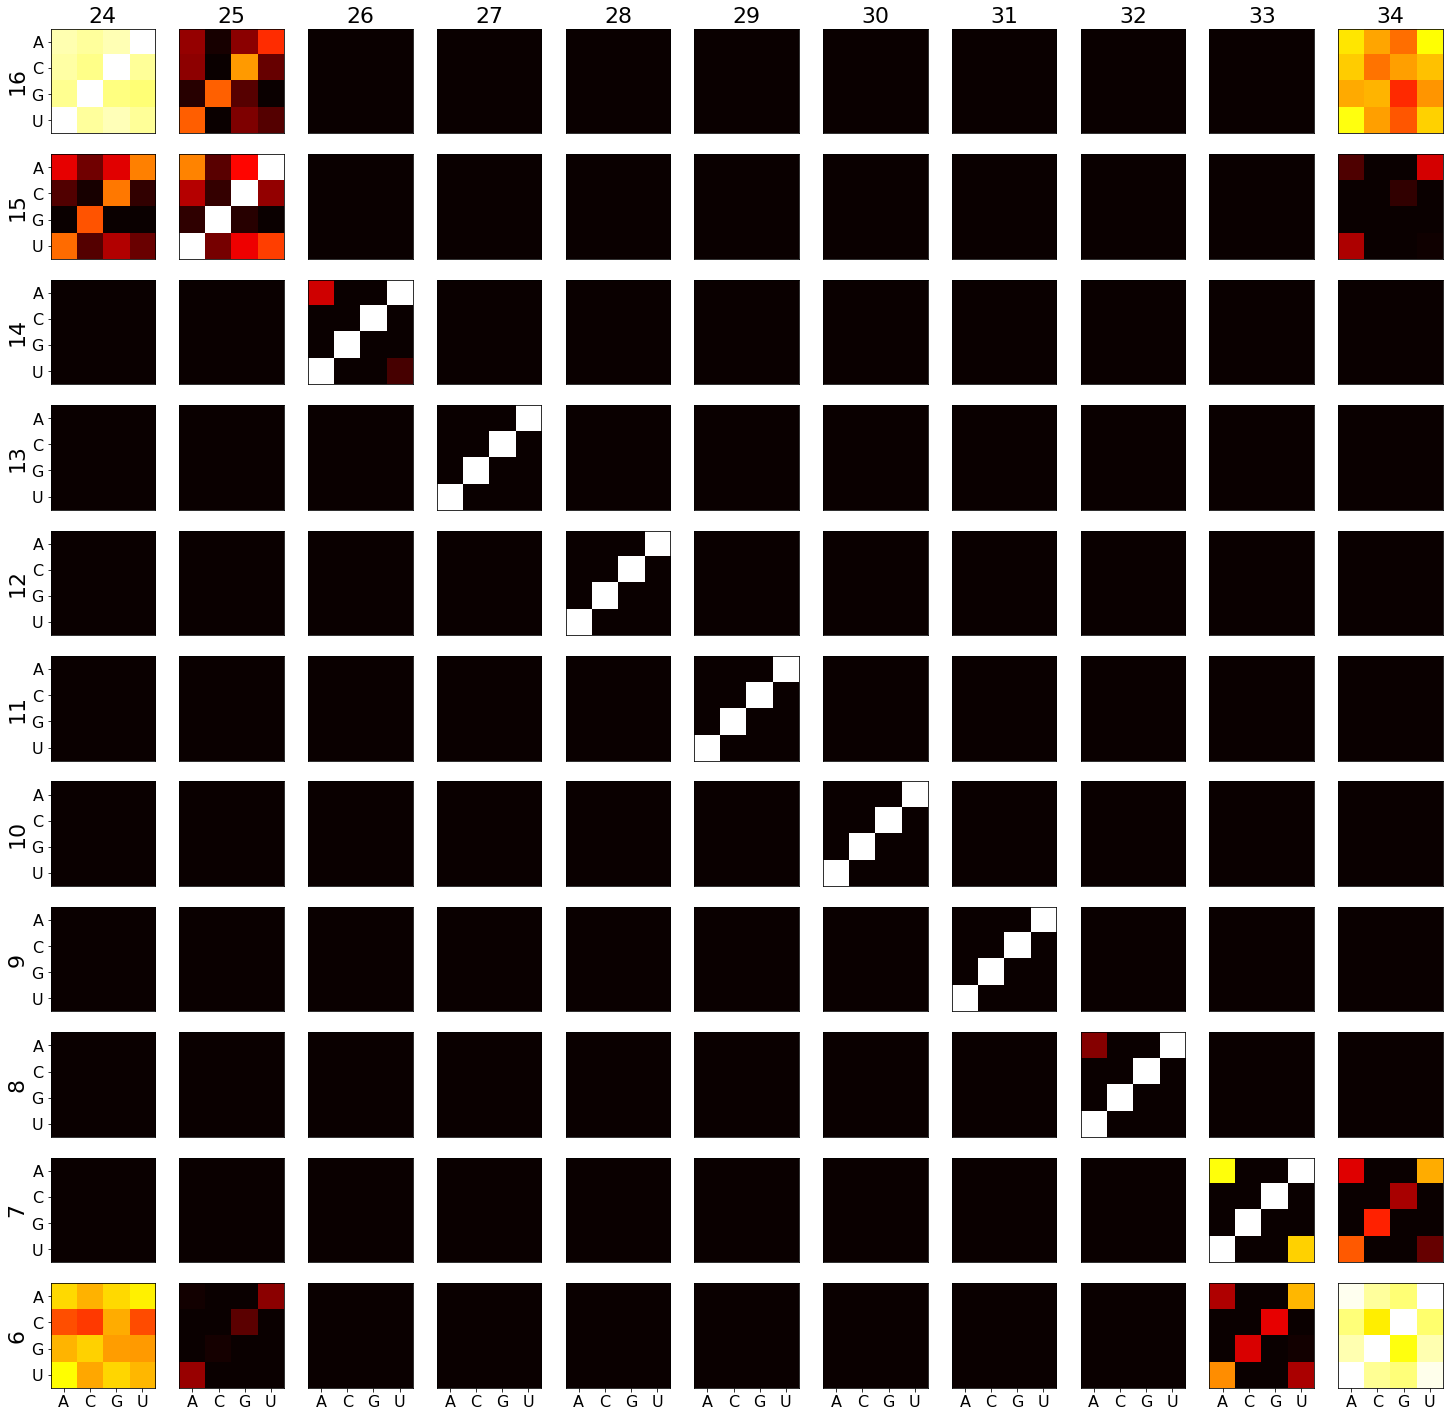

In [28]:
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T

fig = plt.figure(figsize=(25,25))
k = 1
stem1 = range(6,17)[::-1]
stem2 = range(24,35)
for i in stem1:
    for j in stem2:
        plt.subplot(len(stem1),len(stem2),k)
        plt.imshow(mut[i,j,:,:], interpolation='none', cmap='hot', vmin=-1.38, vmax=0.0)
        
        if k in range(1,len(stem1)**2, len(stem1)):
            plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=16)
            plt.ylabel(str(i), fontsize=22)
        else:
            plt.yticks([])
        if k in range(len(stem1)**2-len(stem1)+1,len(stem1)**2+1):
            plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=16)
        else:
            plt.xticks([])

        if k in range(1,len(stem1)+1):
            plt.title(str(j), fontsize=22)
        k += 1

#outfile = os.path.join(save_path, 'second_order_mutagenesis_stem_positions.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')